# &#x1F4F6; [Demodulation of the 5G NR downlink](https://destevez.net/2023/08/demodulation-of-the-5g-nr-downlink/)

In [1]:
file_path = "catkira/1876954_7680KSPS_srsRAN_Project_gnb_short.sigmf-data"
x = read!(file_path, Array{Int32}(undef, 2200544));

In [2]:
 @show size(x), x[1];

(size(x), x[1]) = ((2200544,), 106496)


In [3]:
𝑓ₛ = 7.68e6

# This should be the nominal RF frequency of the subcarrier that we use as DC for demodulation
# (used for NR phase compensation)
f_dc = 1.87695e9

# these are in units of samples and depend on 𝑓ₛ
Tu = 512
Ncp = div(144, 4)
Ncpl = div(144 + 16, 4)

40

In [4]:
# phase correction to apply to symbols 0, 1, 2, 3, 4, 5, 6 in a 0.5 ms interval
p₀ = (f_dc .* (0:6) .* (Tu + Ncp)) / 𝑓ₛ
p₁ = p₀ .% 1
phase_corr = exp.(1im * 2 * π * p₁); @show phase_corr;

phase_corr = ComplexF64[1.0 + 0.0im, 0.29028467725446233 + 0.9569403357322089im, -0.8314696123025453 + 0.5555702330196022im, -0.7730104533627371 - 0.6343932841636453im, 0.38268343236509 - 0.9238795325112866im, 0.9951847266721969 + 0.0980171403295606im, 0.19509032201612833 + 0.9807852804032304im]


In [5]:
cfo = 18.88  # Hz
ϕ₀ = -2.97  # radians
sfo = -3.2e-6  # parts per one
sto_fine = 12.4e-9  # seconds

1.24e-8

In [6]:
# Amplitude adjustment to get symbols of unity amplitude
x = (x[1:2:end] + im * x[2:2:end]) / 2^31 * 24.7; @show x[1,:];


x[1, :] = ComplexF64[0.0012248992919921874 + 0.00023555755615234375im]


In [7]:
# Correct for CFO and phase offset
x .*= exp.(-1im * (2 * π * cfo/𝑓ₛ * (0:length(x)-1) .+ ϕ₀)); @show x[1,:];

x[1, :] = ComplexF64[-0.0012471323880128085 - 2.294437954916597e-5im]


In [8]:
# Pseudo-random sequence
function c_seq(init, length)
    crop = 1600
    x₁ = zeros(UInt8, crop + length)
    x₂ = zeros(UInt8, crop + length)
    x₂[1] = 1

    for j in 1:31
        x₂[j + 1] = (init >> j) & 1
    end

    for j in 1:(length - 31)
        # x1[j + 31] = x1[j + 3] ⊻ x1[j]
        # x₂[j + 31] = x₂[j + 3] ⊻ x₂[j + 2] ⊻ x₂[j + 1] ⊻ x₂[j]
        x₁[j + 31] = x₁[j + 3] ^ x₁[j]
        x₂[j + 31] = x₂[j + 3] ^ x₂[j + 2] ^ x₂[j + 1] ^ x₂[j]
    end

    # return x₁[crop+1:end] ⊻ x₂[crop+1:end]
    return x₁[crop+1:end] ^ x₂[crop+1:end]
end

c_seq (generic function with 1 method)

In [9]:
function plot_ref(ref; ax=nothing, refscale=1)
    const_dict = Dict(
    "bpsk" => [-1, 1],
    "pilot" => [1],
    "qpsk" => [exp(1.0im * (π/2 * k + π/4)) for k in 0:3]
    )

    constant = get(const_dict, ref, nothing) * refscale
    ax = ax isa Nothing ? plt : ax
    scatter!(ax, real(constant), imag(constant), color=:red, markersize=3)
end

function constellation_plot(z::Vector{ComplexF64}; title=nothing, ref="bpsk", ax=nothing, refscale=1, kwargs...)
    ax = ax isa Nothing ? plot(size=(300, 300)) : ax
    scatter!(ax, real(z), imag(z), kwargs...)
    plot_ref(ref, ax=ax, refscale=refscale)
    plot!(ax, aspect_ratio=:equal, xlims=(-1.5, 1.5), ylims=(-1.5, 1.5), xticks=[], yticks=[])
    # title && title!(ax, title)
    if title !== nothing
        title!(ax, title)
    end
end

constellation_plot (generic function with 1 method)

In [10]:
cp_corr = zeros(ComplexF64, round(Int, 𝑓ₛ * 0.4e-3)); @show size(cp_corr);
corr_start = round(Int, 9.05e-3 * 𝑓ₛ); @show corr_start;
for j in 1:length(cp_corr)
    y = x[corr_start + j:corr_start + j + Ncp + Tu - 1]
    cp_corr[j] = sum(y[1:Ncp] .* conj.(y[end-Ncp+1:end]))
end

t_corr = 1e3 * (collect(0:length(cp_corr)-1) .+ corr_start) / 𝑓ₛ; @show t_corr[1];

size(cp_corr) = (3072,)
corr_start = 69504
t_corr[1] = 9.05


In [11]:
using Plots

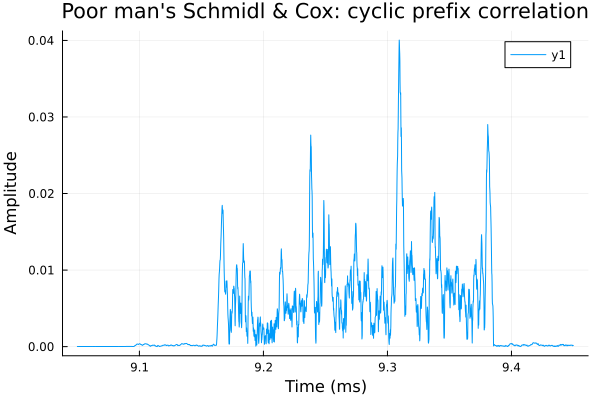

In [12]:
plot(t_corr, abs.(cp_corr)
    , xlabel="Time (ms)"
    , ylabel="Amplitude"
    , title="Poor man's Schmidl & Cox: cyclic prefix correlation"
)

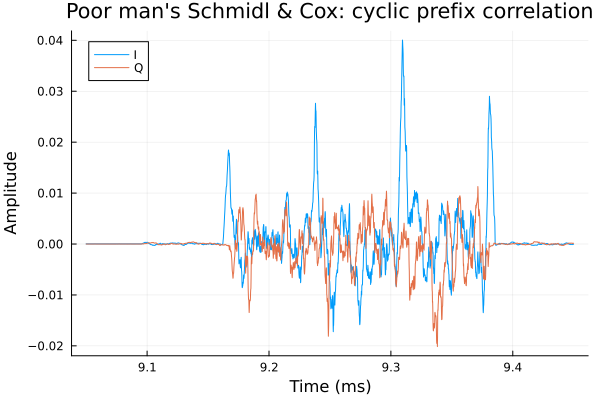

In [13]:
plot(t_corr, real.(cp_corr), label="I")
plot!(t_corr, imag.(cp_corr), label="Q")

xlabel!("Time (ms)")
ylabel!("Amplitude")
title!("Poor man's Schmidl & Cox: cyclic prefix correlation")

In [14]:
m₀ = argmax(abs.(cp_corr[1:1001]))
m₁ = argmax(abs.(cp_corr[1001:1501])) + 1000
m₂ = argmax(abs.(cp_corr[1501:2251])) + 1500
m₃ = argmax(abs.(cp_corr[2251:end])) + 2250;

In [15]:
@show [m₀, m₁, m₂, m₃];
@show cp_corr[[m₀, m₁, m₂, m₃]];
@show (𝑓ₛ / Tu); 

[m₀, m₁, m₂, m₃] = [898, 1446, 1994, 2542]
cp_corr[[m₀, m₁, m₂, m₃]] = ComplexF64[0.018453364171738606 - 0.0003259523120684487im, 0.027630909489268485 + 7.182197607671998e-5im, 0.040046193419243564 - 9.265369157174103e-5im, 0.029007430983299793 - 0.0005109672994236703im]
𝑓ₛ / Tu = 15000.0


In [16]:
CFO_est = -angle.(cp_corr[[m₀, m₁, m₂, m₃]]) / (2 * π) * (𝑓ₛ / Tu); @show CFO_est;

CFO_est = [42.1642853098759, -6.205440021172319, 5.5234713106478015, 42.04848156374781]


## PSS demodulation

In [17]:
using FFTW, DSP

In [18]:
# Start demodulation at the middle of the cyclic prefix for maximum robustness to STO
a₀ = corr_start + m₀ + div(Ncp, 2); @show a₀, corr_start, m₀, div(Ncp,2)

𝐹ₓ = DSP.fftshift(DSP.fft(x[a₀:(a₀+Tu)-1])); @show size(𝐹ₓ), 𝐹ₓ[1];
# Correct for the 5G NR upconversion discontinuity
# This PSS is transmitted on symbol 2 mod 7
𝐹ₓ .*= phase_corr[3]; @show phase_corr[3], 𝐹ₓ[1];
# tu_fft = ; @show Tu, size(tu_fft), tu_fft[1];
# Correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
𝐹ₓ .*= exp.(1im * 2π .* DSP.fftshift(DSP.fftfreq(Tu)) * Ncp / 2); @show 𝐹ₓ[1], size(𝐹ₓ);

(a₀, corr_start, m₀, div(Ncp, 2)) = (70420, 69504, 898, 18)
(size(𝐹ₓ), 𝐹ₓ[1]) = ((512,), -0.0010115171292286451 + 0.004078899947208892im)
(phase_corr[3], 𝐹ₓ[1]) = (-0.8314696123025453 + 0.5555702330196022im, -0.0014250696388573615 - 0.003953450164915527im)
(𝐹ₓ[1], size(𝐹ₓ)) = (-0.0014250696388573528 - 0.003953450164915531im, (512,))


In [19]:
# The PSS ocuppies subcarriers 56 to 128 relative to the start of an SS/PBCH block
# In this case, the SS/PBCH block starts at subcarrier -120 (with respect to the
# subcarrier we have decided to treat as DC). This means that the SS/PBCH block is
# not centred with respect to this choice of DC (but this doesn't matter).
pss_sc_sel = range(Int(Tu/2-120+57), Int(Tu/2-120+56+127))

193:319

In [20]:
# x_all_sc = np.arange(f.size) - Tu//2; y_all_sc = 10*np.log10(np.abs(f)**2);
x_all_sc = collect(0:size(𝐹ₓ,1)) .- div(Tu, 2); y_all_sc = 10 * log10.(abs2.(𝐹ₓ));
@show x_all_sc[1]; @show y_all_sc[1];

x_all_sc[1] = -256
y_all_sc[1] = -47.52994750364866


In [21]:
# x_pss_sc = np.arange(f.size)[pss_sc_sel] - Tu//2; y_pss_sc = 10*np.log10(np.abs(f[pss_sc_sel])**2)
x_pss_sc = collect(0:size(𝐹ₓ,1))[pss_sc_sel] .- div(Tu, 2); y_pss_sc = 10 * log10.(abs2.(𝐹ₓ[pss_sc_sel]));
@show x_pss_sc[1]; @show y_pss_sc[1];

x_pss_sc[1] = -64
y_pss_sc[1] = 0.27802604993433233


In [22]:
all_sb_plot = 
scatter(x_all_sc, y_all_sc
    , label="All subcarriers"
    , markersize=5
)
scatter!(x_pss_sc, y_pss_sc
    , label="PSS subcarriers"
    , markershape=:vline
    , markersize=5
)

title!("PSS subcarrier power")
xlabel!("Subcarrier number (DC = 0)")
ylabel!("Power (dB)")

savefig(all_sb_plot,"images/all_sb_plot.png");

<img src=images/all_sb_plot.png width='' heigth='' > </img>

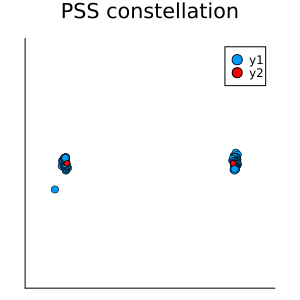

In [23]:
pss_sym_demod = 𝐹ₓ[pss_sc_sel];
constellation_plot(pss_sym_demod, title="PSS constellation")

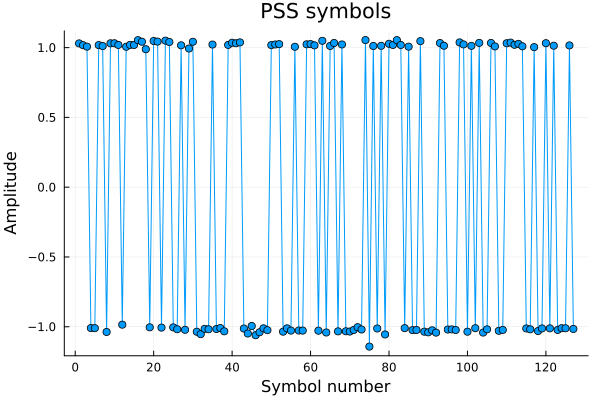

In [24]:
plot(real(pss_sym_demod), marker=:circle, label="")
title!("PSS symbols")
xlabel!("Symbol number")
ylabel!("Amplitude")

In [25]:
function pss_sequence(nid2)
    x = zeros(UInt8, 127)
    x[1:7] .= [1, 1, 1, 0, 1, 1, 0][end:-1:1]

    for j in 8:127
        x[j] = x[j - 3] ^ x[j - 6]
    end

    indices = x[(collect(1:127) .+ 43 * nid2) .% 127 .+ 1]
    return 1.0 .- 2.0 .* float.(indices)
end

pss_sequence (generic function with 1 method)

In [26]:
size(pss_sym_demod)

(127,)

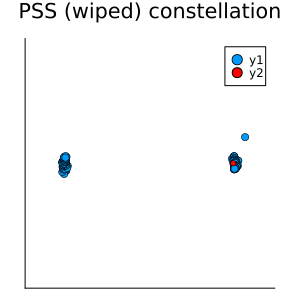

In [27]:
pss_sym_demod_wipe = float(pss_sym_demod) .* pss_sequence(1);
constellation_plot(pss_sym_demod_wipe, title="PSS (wiped) constellation", ref="pilot")

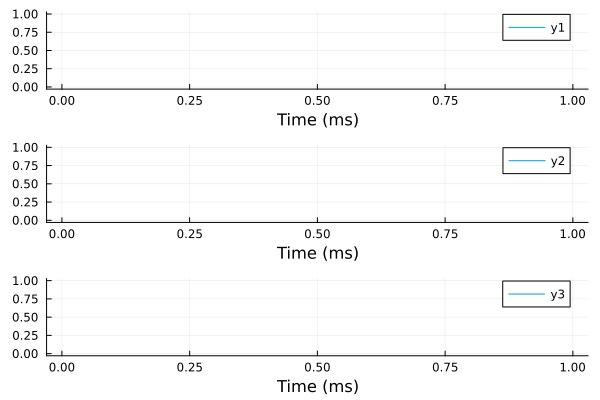

In [72]:

# fig, axs = subplots(3, 1, sharex=true, sharey=true)
plot(layout=(3, 1), sharex=true, sharey=true)

axs = 1:1:3

for nid2 in 1:3
    pss_re = zeros(ComplexF64, Tu)
    pss_re[pss_sc_sel] .= pss_sequence(nid2)
    pss_sym = ifft(fftshift(pss_re))
    pss_corr = zeros(ComplexF64, round(Int, 𝑓ₛ * 1e-3))
    time_corr_start = round(Int, 8.75e-3 * 𝑓ₛ)

    for j in 1:length(pss_corr)
        pss_corr[j] = sum(x[time_corr_start + j:end][1:Tu] .* conj.(DSP.reverse(pss_sym)))
    end

    tcorr = 1e3 * (time_corr_start .+ 1:length(pss_corr)) / 𝑓ₛ
    # plot!(axs[nid2], tcorr, abs.(pss_corr), label=""); @show tcorr, abs.(pss_corr)
    # text!(axs[nid2], tcorr[div(end, 16)], 0.15, "\$N^{{\\mathrm{{(ID)}}}}_2\$ = $nid2")
    # annotate!(axs[nid2], text("\$N^{{\\mathrm{{(ID)}}}}_2\$ = $nid2", 8), tcorr[div(end, 16)], 0.15)
# annotate!(axs[nid2], text("\$N^{{\\mathrm{{(ID)}}}}_2\$ = $nid2", 8), 1, 0.15)

end

plot!(axs[end], xlabel="Time (ms)")
# suptitle!("PSS time domain correlation", y=0.93)

## PSS time domain correlation

In [73]:
NID2 = 1

1

## SSS demodulation

In [74]:
s_part = x[a₀ + 2 * (Ncp + Tu):end][1:Tu]; @show s_part[1], size(s_part);

(s_part[1], size(s_part)) = (3.08536665057698e-5 - 0.03888399804943803im, (512,))


In [75]:
𝐹ₓ = DSP.fftshift(DSP.fft(s_part)); @show size(𝐹ₓ), 𝐹ₓ[1];
# Correct for the 5G NR upconversion discontinuity
# This PSS is transmitted on symbol 4 mod 7
𝐹ₓ .*= phase_corr[4]; @show phase_corr[4], 𝐹ₓ[1];

# Correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
𝐹ₓ .*= exp.(1im * 2π .* DSP.fftshift(DSP.fftfreq(Tu)) * Ncp / 2); @show 𝐹ₓ[1], size(𝐹ₓ);

(size(𝐹ₓ), 𝐹ₓ[1]) = ((512,), 0.0034931447211957734 - 0.016401492538691775im)
(phase_corr[4], 𝐹ₓ[1]) = (-0.7730104533627371 - 0.6343932841636453im, -0.013105234101399396 + 0.010462497631421392im)
(𝐹ₓ[1], size(𝐹ₓ)) = (-0.013105234101399419 + 0.010462497631421363im, (512,))


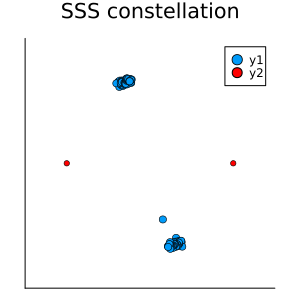

In [76]:
sss_sym_demod = 𝐹ₓ[pss_sc_sel]
constellation_plot(sss_sym_demod, title="SSS constellation")

In [77]:
function sss_sequence(Nᵢ₋¹, Nᵢ₋², Onlyₓ¹=false, Noₓ¹=false)
    x₀ = zeros(UInt8, 127)
    x₁ = zeros(UInt8, 127)
    x₀[1] = 1
    x₁[1] = 1
    
    for j in 1:(127 - 7)
        x₀[j + 7] = x₀[j + 4] ^ x₀[j]
        x₁[j + 7] = x₁[j + 1] ^ x₁[j]
    end
    
    if Onlyₓ¹
        return 1 .- 2 * Float64.(x₁)
    end
    
    m₀ = 15 * (Nᵢ₋¹ ÷ 112) + 5 * Nᵢ₋²
    m₁ = Nᵢ₋¹ % 112

    Iₓ⁰ = (collect(1:127) .+ m₀) .% 127 .+ 1
    Iₓ¹ = (collect(1:127) .+ m₁) .% 127 .+ 1
    
    if Noₓ¹
        return 1 .- 2 * Float64.(x₀[Iₓ⁰])
    else
        x = (1 .- 2 * Float64.(x₀[Iₓ⁰]))
        y = (1 .- 2 * Float64.(x₁[Iₓ¹]))
        return  x .* y            
    end
    
end

sss_sequence (generic function with 3 methods)

In [78]:
using Statistics

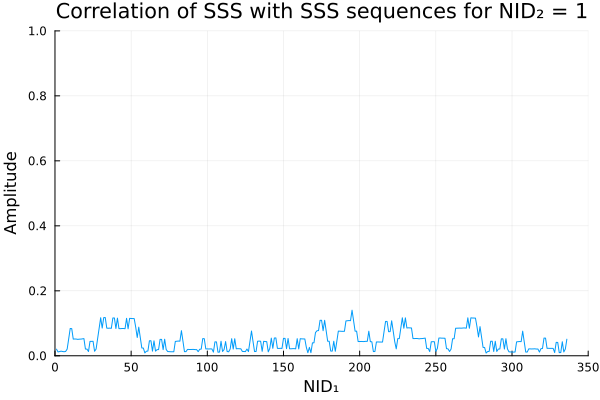

In [79]:
sss_corrs = zeros(ComplexF64, 336)
for j in 1:length(sss_corrs)
    sss_corrs[j] = mean(sss_sym_demod .* sss_sequence(j, NID2))
end

plot(abs.(sss_corrs),
    title = "Correlation of SSS with SSS sequences for NID₂ = $NID2",
    xlabel = "NID₁",
    ylabel = "Amplitude",
    xlims  =(0.0, 350.0),
    ylims  =(0.0, 1.0),
    legend = false)